In [1]:
# import models
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,KBinsDiscretizer,minmax_scale
from sklearn.model_selection import train_test_split
import seaborn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# read data
path = ".\\loans.csv"

df = pd.read_csv(path)
print(df.shape)
df.head()

(443, 8)


,client_id,loan_type,loan_amount,repaid,loan_id,loan_start,loan_end,rate
0,46109,home,13672,0,10243,2002-04-16,2003-12-20,2.15
1,46109,credit,9794,0,10984,2003-10-21,2005-07-17,1.25
2,46109,home,12734,1,10990,2006-02-01,2007-07-05,0.68
3,46109,cash,12518,1,10596,2010-12-08,2013-05-05,1.24
4,46109,credit,14049,1,11415,2010-07-07,2012-05-21,3.13


In [3]:
# check for empty values
df.isnull().sum()

client_id      0
loan_type      0
loan_amount    0
repaid         0
loan_id        0
loan_start     0
loan_end       0
rate           0
dtype: int64

In [4]:
# range of safe value ( not noise )
def eval_field_range(x:np.ndarray):

    alpha = 1.5#0.4

    # mean,std = x.mean(),x.std()
    # return (mean-std , mean + std)

    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)

    IQR = q3 -q1

    return (
        (q1-alpha*IQR),
        (q3+alpha*IQR)
    )



range_ = eval_field_range(df["loan_amount"])
print('range: ', range_)

range:  (-7027.25, 22998.75)


In [5]:
# found noise value

noise_df = df[(df["loan_amount"]<range_[0]) | (df["loan_amount"]>range_[1])]

print('noise_df.shape: ', noise_df.shape)
noise_df.head()

noise_df.shape:  (0, 8)


,client_id,loan_type,loan_amount,repaid,loan_id,loan_start,loan_end,rate


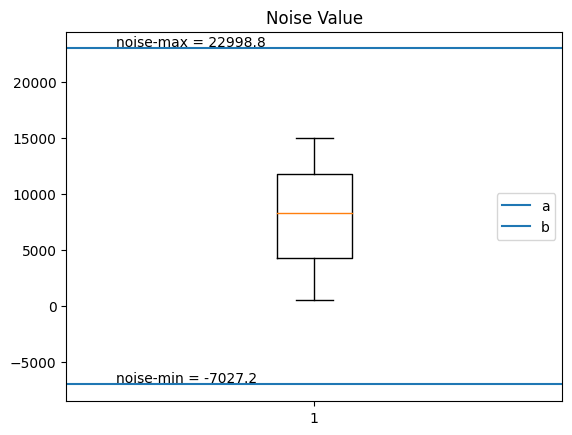

In [6]:
# make plot for noise values
plt.title("Noise Value")


r1,r2 = range_

plt.axhline(r1)
plt.axhline(r2)


plt.scatter([1]*noise_df.shape[0],noise_df["loan_amount"],c="r")

plt.text(0.6,r1+200,f"noise-min = {r1:.1f}")
plt.text(0.6,r2+200,f"noise-max = {r2:.1f}")

plt.legend(["a","b"])
plt.boxplot(df["loan_amount"])
plt.show()

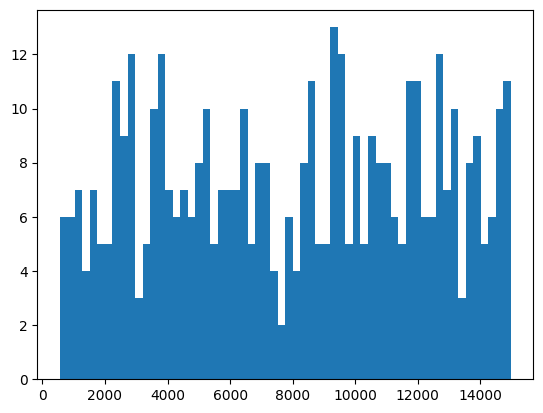

In [7]:
# how hist plot of data
plt.hist(df["loan_amount"],bins=60)
plt.show()

In [8]:
# correct data with out noise
df = df[(df["loan_amount"]>range_[0]) & (df["loan_amount"]<range_[1])]

print('df.shape: ', df.shape)
df.head()

df.shape:  (443, 8)


,client_id,loan_type,loan_amount,repaid,loan_id,loan_start,loan_end,rate
0,46109,home,13672,0,10243,2002-04-16,2003-12-20,2.15
1,46109,credit,9794,0,10984,2003-10-21,2005-07-17,1.25
2,46109,home,12734,1,10990,2006-02-01,2007-07-05,0.68
3,46109,cash,12518,1,10596,2010-12-08,2013-05-05,1.24
4,46109,credit,14049,1,11415,2010-07-07,2012-05-21,3.13


In [9]:
# make fields [loan type , loan start , loan end , rate] to number => rate field : k bin discretizer
# PART 1 -> label encoder

df["loan_type"] = LabelEncoder().fit_transform(df["loan_type"])

In [10]:
# make fields [loan type , loan start , loan end , rate] to number => rate field : k bin discretizer
# PART 1 -> k bin discretizer


print('df.rate.max: ', df["rate"].max())
print('df.rate.min: ', df["rate"].min())

df["rate"] = KBinsDiscretizer(n_bins=5,
                 encode="ordinal",
                 strategy="uniform"
                 ).fit_transform(df[["rate"]])


df.rate.max:  12.62
df.rate.min:  0.01


c:\Users\MEDIA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [11]:
# function to convert date to number:int

def date_to_num(date:str) -> int:
    year,month,day = date.split("-")

    return (int(year)*365) + (int(month) * 31) + int(day)


# convert date

df["loan_start"] = df["loan_start"].apply(date_to_num)
df[ "loan_end" ] = df[ "loan_end" ].apply(date_to_num)

In [12]:
df.head()

,client_id,loan_type,loan_amount,repaid,loan_id,loan_start,loan_end,rate
0,46109,2,13672,0,10243,730870,731487,0.0
1,46109,1,9794,0,10984,731426,732059,0.0
2,46109,2,12734,1,10990,732253,732777,0.0
3,46109,0,12518,1,10596,734030,734905,0.0
4,46109,1,14049,1,11415,733874,734556,1.0


In [13]:
# make values normalize

df_data = df.values

min_max_model = MinMaxScaler()


res = min_max_model.fit_transform(df_data)

In [14]:
# make new normalized data
new_df = pd.DataFrame()

for column ,i in zip(df.columns,range(len(df.columns))):
    new_df[column] = res[:,i]

new_df.head()

,client_id,loan_type,loan_amount,repaid,loan_id,loan_start,loan_end,rate
0,0.853033,0.666667,0.909867,0.0,0.118063,0.150416,0.151599,0.00
1,0.853033,0.333333,0.640785,0.0,0.491927,0.253284,0.251043,0.00
2,0.853033,0.666667,0.844782,1.0,0.494955,0.406290,0.375869,0.00
3,0.853033,0.000000,0.829795,1.0,0.296165,0.735060,0.745828,0.00
4,0.853033,0.333333,0.936026,1.0,0.709384,0.706198,0.685153,0.25


# **رگنسیون یک متغیره**

<Axes: >

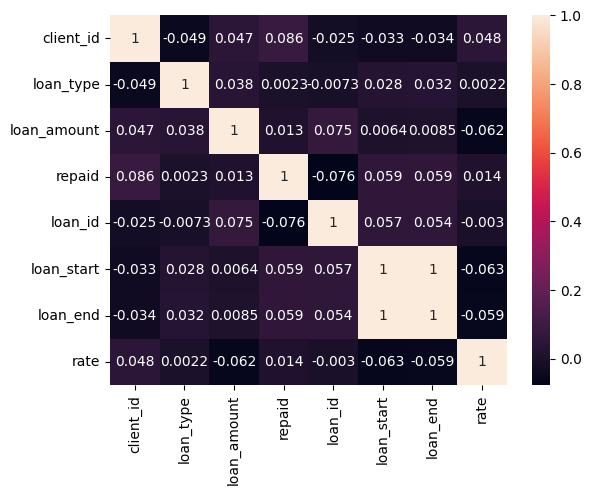

In [15]:
# heatmap for columns corr

seaborn.heatmap(new_df.corr(),annot=True)

In [16]:
# split x and y data

x = new_df["loan_start"].values
print('x: ', x.shape)
y = new_df["loan_amount"].values
print('y: ', y.shape)

x:  (443,)
y:  (443,)


In [17]:
# split train and test data

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1,random_state=42)
print('y_test: ', y_test.shape)
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape)
print('x_train: ', x_train.shape)

x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)


y_test:  (45,)
y_train:  (398,)
x_test:  (45,)
x_train:  (398,)


In [18]:
# fit model

model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

model score : -0.016149354704434238


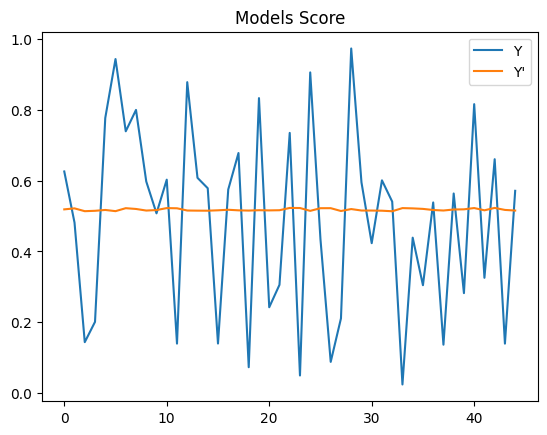

In [19]:
# plot models score 

print(f"model score : {model.score(x_test,y_test)}")

plt.title("Models Score")
plt.plot(y_test)
plt.plot(model.predict(x_test))
plt.legend(["Y","Y'"])

# **رگنسیون خطی چند متغیره**

In [20]:
# drop ids column from data

new_df.drop(["client_id","loan_id"],axis=1,inplace=True)
new_df.head()

,loan_type,loan_amount,repaid,loan_start,loan_end,rate
0,0.666667,0.909867,0.0,0.150416,0.151599,0.00
1,0.333333,0.640785,0.0,0.253284,0.251043,0.00
2,0.666667,0.844782,1.0,0.406290,0.375869,0.00
3,0.000000,0.829795,1.0,0.735060,0.745828,0.00
4,0.333333,0.936026,1.0,0.706198,0.685153,0.25


In [21]:
# split x and y data

x = new_df.drop("loan_amount",axis=1).values
print('x: ', x.shape)
y = new_df["loan_amount"]
print('y: ', y.shape)


x:  (443, 5)
y:  (443,)


In [22]:
# split train and test data

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1,random_state=42)
print('y_test: ', y_test.shape)
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape)
print('x_train: ', x_train.shape)

y_test:  (45,)
y_train:  (398,)
x_test:  (45, 5)
x_train:  (398, 5)


In [23]:
# fir mdoel

model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

Score : -0.0300042575018582


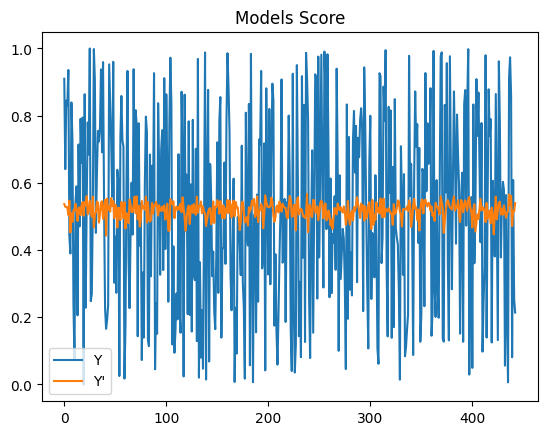

In [24]:
# plot for model score

print(f"Score : {model.score(x_test,y_test)}")

plt.title("Models Score")
plt.plot(y)
plt.plot(model.predict(x))
plt.legend(["Y","Y'"])

# **رگنسیون چند جمله ای**

In [25]:
# split x and y data

x = new_df.drop("loan_amount",axis=1).values
print('x: ', x.shape)
y = new_df["loan_amount"]
print('y: ', y.shape)

x:  (443, 5)
y:  (443,)


In [26]:
# split train amd test data

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1,random_state=42)
print('y_test: ', y_test.shape)
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape)
print('x_train: ', x_train.shape)

y_test:  (45,)
y_train:  (398,)
x_test:  (45, 5)
x_train:  (398, 5)


In [27]:
# fit model for polynomial data (x)

degree = 2

pf = PolynomialFeatures(degree=degree)

x_train = pf.fit_transform(x_train)
x_test = pf.fit_transform(x_test)

print('x_test: ', x_test.shape)
print('x_train: ', x_train.shape)


model = LinearRegression()
model.fit(x_train,y_train)
print(model.score(x_test,y_test))

x_test:  (45, 21)
x_train:  (398, 21)
0.02836446739159526


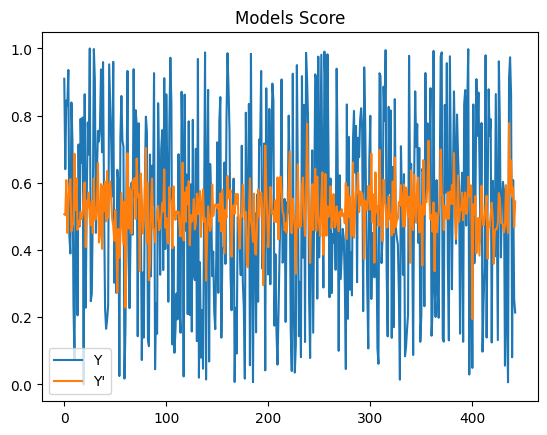

In [31]:
# make a plot for model

plt.title("Models Score")
plt.plot(y)
plt.plot(model.predict(pf.fit_transform(x)))
plt.legend(["Y","Y'"])